In [1]:
using Catalyst: spatial_convert_err
include("../src/DiscreteStochasticSimulation.jl")
using .DiscreteStochasticSimulation
using Catalyst
using ProgressMeter
using Plots
using Expokit
using DifferentialEquations
using OrdinaryDiffEq

## Lotka Volterra Chemical Reaction Network Definition using Catalyst.jl DSL

In [2]:
 local k₁, k₂, k₃, X, Y
  rn = @reaction_network begin
    k₁, X --> 2X
    k₂, X + Y --> 2Y
    k₃, Y --> 0
  end

Model ##ReactionSystem#231
Unknowns (2):
  X(t)
  Y(t)
Parameters (3):
  k₁
  k₂
  k₃

## Plug in the reaction network structure into the discrete system wrapper

In [3]:
model = DiscreteStochasticSystem(rn);

## Define boundary condition function

Rectangular lattice simply means the solver won't consider states beyond the limits

In [4]:
 # define boundaries (rectangular lattice in this case)
bounds = (0, 500) #(lower limit, upper limit)
boundary_condition(x) = RectLatticeBoundaryCondition(x, bounds);

## Define initial state and place it in a set, then expand the space 

In [5]:
# define initial value and expand the space a bit 
U₀ = CartesianIndex(50, 100)
X = Set([U₀])
X = Expand!(X, model, boundary_condition, 2);

## Define a probability density vector over the initial state space and set the probability of initial value to 1 (rest to zero)

In [6]:
 # initial probability vector (only for active states)
p₀ = zeros(X |> length)
p₀[DiscreteStochasticSimulation.FindElement(U₀, X)] = 1

# probability values for the entire state space (visalization only)
P = zeros(bounds[2], bounds[2]);
P1 = zeros(bounds[2], bounds[2]); # this will hold active states

## Run the simulation (sliding windows algorithm for fiite state projection)

In [7]:
δt = 0.01
global iter = 1
global pₜ = p₀

# time intrerval 
T = 0:0.01:20

sol = zeros(length(T), size(P)...)
sizes = zeros(length(T), size(P)...)

@showprogress for t ∈ T
    
  #expand space and assemble matrix
  global X, pₜ = Expand!(X, pₜ, model, boundary_condition, 7)
  A = MasterEquation(X, model, [1.0, 0.005, 0.6], boundary_condition, t)
    
  # solve system and normalize (using expokit (can also use numerical time steppers such as Runge-Kutta))
  global pₜ = expmv(δt, A, pₜ)
  pₜ /= sum(pₜ)
    
  # purge lowest 80% probability states (most will be zero; this is arbitrary as of now)
  X, pₜ = Purge!(X, pₜ, 60)
    
  # set probability values to full space for visualization using heatmap
  P .= 0 
  P1 .= 0
  P[X|>collect] = pₜ
  P1[X|>collect] .= 1

  sol[iter, :, :] .= P 
  sizes[iter, :, :] .= P1
  iter+=1
     
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:12


[ Info: Saved animation to /home/adiden/DiscreteStochasticSimulation/examples/anim_fps15.gif


Plots.AnimatedGif("/home/adiden/DiscreteStochasticSimulation/examples/anim_fps15.gif")
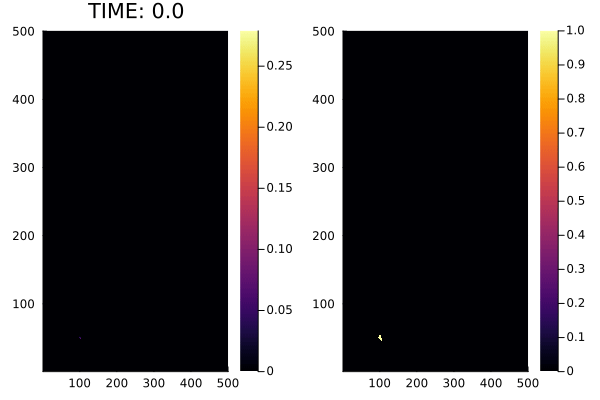

In [8]:
a = @animate for i ∈ 1:length(T)
    h = heatmap(sol[i, :, :])
    s = heatmap(sizes[i, :, :])
    title!(h, "TIME: $(T[i])")
    plot(h, s)
end every 20
gif(a, "anim_fps15.gif")

In [9]:
cart2vec(x) = [Tuple(x)...]
points = cart2vec.(CartesianIndices(sol[1, :, :]))
sol_mean = @showprogress map(1:length(T)) do i
    local vals =  points .* sol[i, :, :] 
    sum([vals...])
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


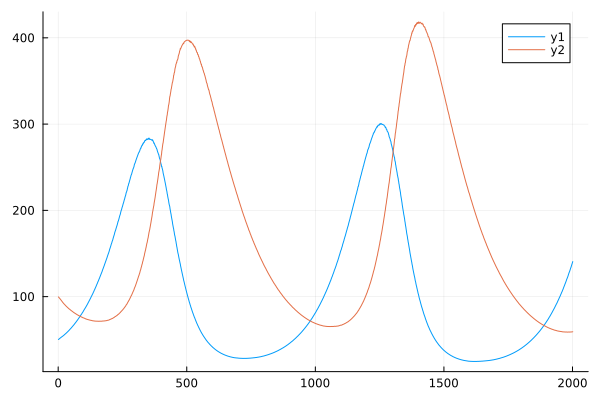

In [20]:
x = [sol_mean[i][1] for i ∈ 1:length(sol_mean)]
y = [sol_mean[i][2] for i ∈ 1:length(sol_mean)]
plot(x)
plot!(y)

In [23]:
# Create an ODE that can be simulated.
u0 = [:X=>50, :Y=>100]
tspan = (0., 20.)
ps = [:k₁=>1.0, :k₂=>0.005, :k₃=>0.6]
ode = ODEProblem(rn, u0, tspan, ps)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 20.0)
u0: 2-element Vector{Float64}:
  50.0
 100.0

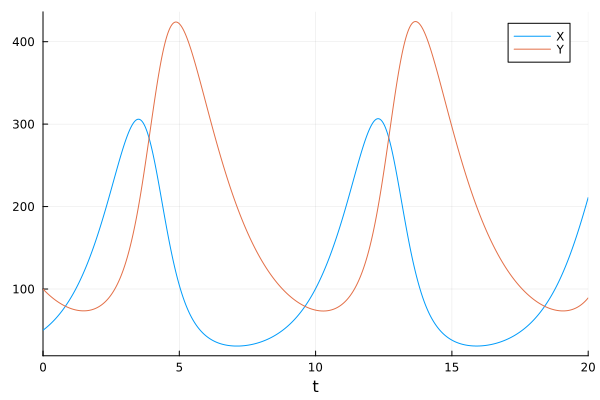

In [24]:
# Simulate ODE and plot results.
sol = solve(ode)
plot(sol)

In [53]:
jinput = JumpInputs(rn, u0, tspan, ps)
jprob = JumpProblem(jinput)
jump_sol = solve(jprob,  SSAStepper(), saveat=0.1)

retcode: Success
Interpolation: Piecewise constant interpolation
t: 7104-element Vector{Float64}:
  0.0
  0.010233503868979643
  0.012084606145366366
  0.012596821520890263
  0.013162726175769362
  0.013742350766337614
  0.028835995224540716
  0.03154949166235282
  0.036162311272058545
  0.03697902981426217
  0.04294970341603917
  0.044556009279801856
  0.04690900702909236
  ⋮
 19.979828707833573
 19.979863985388025
 19.980185581823065
 19.981476073653482
 19.981660998306744
 19.985118491998822
 19.987008515989906
 19.987849759790116
 19.988293950621312
 19.992202212044305
 19.997666310202593
 20.0
u: 7104-element Vector{Vector{Int64}}:
 [50, 100]
 [51, 100]
 [51, 99]
 [52, 99]
 [52, 98]
 [53, 98]
 [53, 97]
 [54, 97]
 [53, 98]
 [54, 98]
 [53, 99]
 [54, 99]
 [54, 98]
 ⋮
 [119, 230]
 [119, 229]
 [118, 230]
 [119, 230]
 [119, 229]
 [119, 228]
 [120, 228]
 [120, 227]
 [120, 226]
 [121, 226]
 [120, 227]
 [120, 227]